# TuRBO Bayesian Optimization
In this tutorial we demonstrate the use of Xopt to preform Trust Region Bayesian
Optimization (TuRBO) on a simple test problem. During optimization of high
dimensional input spaces off the shelf BO tends to over-emphasize exploration which
severely degrades optimization performance. TuRBO attempts to prevent this by
maintaining a surrogate model over a local (trust) region centered on the best
observation so far and restricting optimization inside that local region. The trust
region is expanded and contracted based on the number of `successful` (observations
that improve over the best observed point) or `unsuccessful` (no improvement)
observations in a row. See https://botorch.org/tutorials/turbo_1 for details.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize a
function in the domian [0,2*pi]. Note that the function used to evaluate the
objective function takes a dictionary as input and returns a dictionary as the output.

In [1]:
from xopt.vocs import VOCS
import math

# define variables and function objectives
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
)

In [2]:
# define a test function to optimize
import numpy as np

def sin_function(input_dict):
    x = input_dict["x"]
    return {"f": -10*np.exp(-(x - np.pi)**2 / 0.01) + 0.5*np.sin(5*x)}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acqusition function to perform Bayesian Optimization.

In [3]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt import Xopt

evaluator = Evaluator(function=sin_function)
options = UpperConfidenceBoundGenerator.default_options()
options.optim.use_turbo = True
generator = UpperConfidenceBoundGenerator(vocs, options)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [4]:
options

UCBOptions(optim=OptimOptions(num_restarts=20, raw_samples=20, sequential=True, max_travel_distances=None, use_turbo=True), acq=UpperConfidenceBoundOptions(proximal_lengthscales=None, use_transformed_proximal_weights=True, monte_carlo_samples=128, beta=2.0), model=ModelOptions(name='standard', custom_constructor=None, use_low_noise_prior=True, covar_modules={}, mean_modules={}), n_initial=3, use_cuda=False)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [5]:
import pandas as pd
X.evaluate_data(pd.DataFrame({"x":[3.0, 1.75, 2.0]}))

# inspect the gathered data
X.data

,x,f,xopt_runtime,xopt_error
1,3.00,-1.021664,0.000016,False
2,1.75,0.312362,0.000004,False
3,2.00,-0.272011,0.000002,False


In [6]:
# determine trust region from gathered data
import torch
generator.train_model()
generator.get_trust_region(torch.tensor(vocs.bounds))

tensor([[1.4292],
        [4.5708]], dtype=torch.float64)

## Do bayesian optimization steps
Notice that when the number of successive successes or failures reaches 2 the trust
region expands or contracts and counters are reset to zero. Counters are also reset
to zero during alternate successes/failures. Finally, the model is most accurate
inside the trust region, which supports our goal of local optimization.

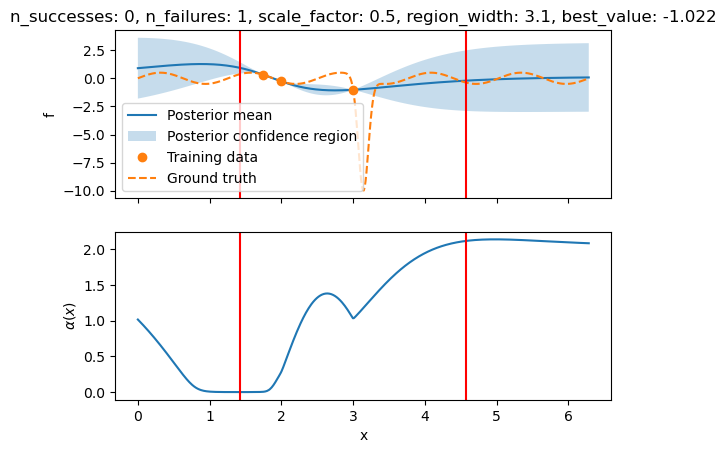

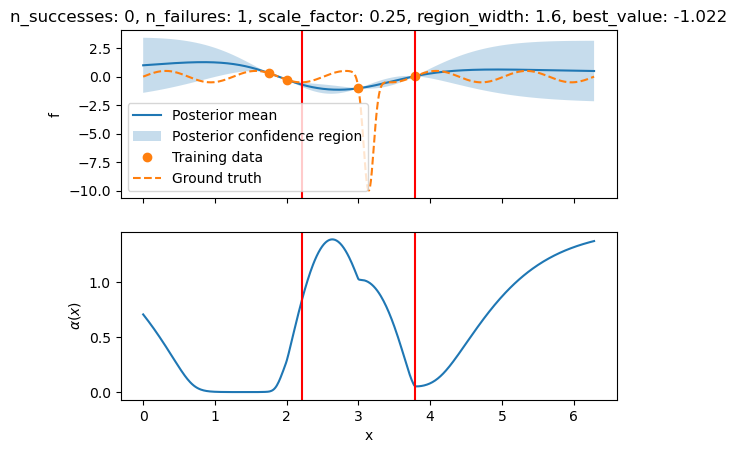

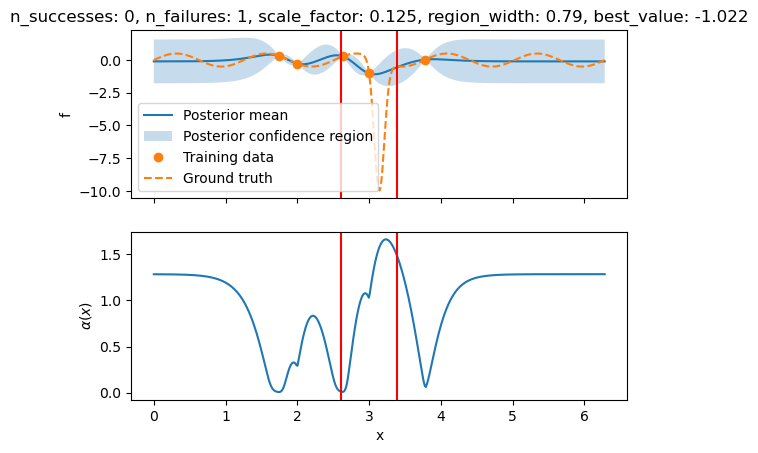

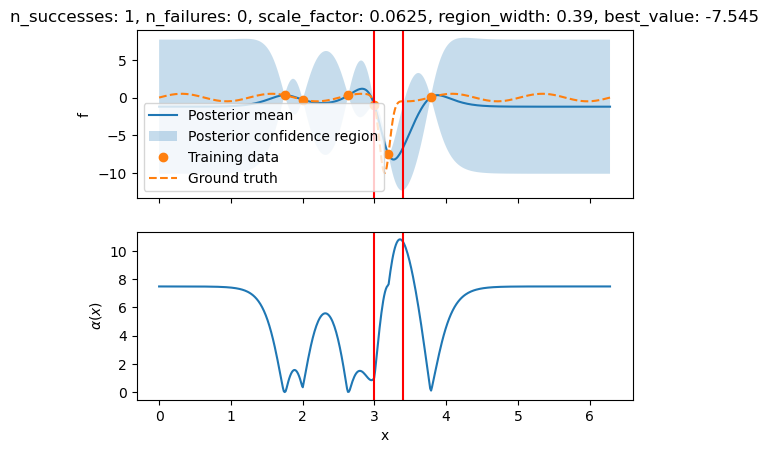

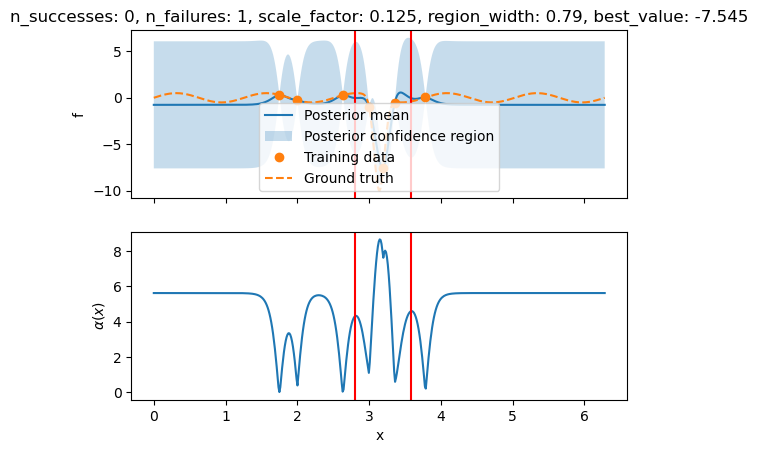

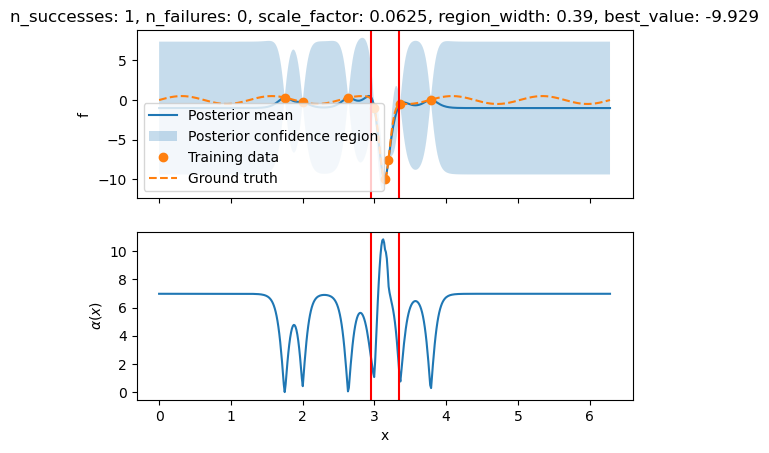

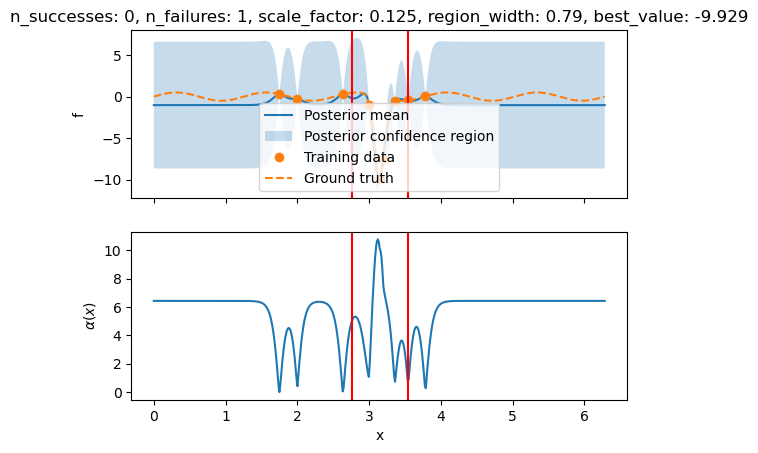

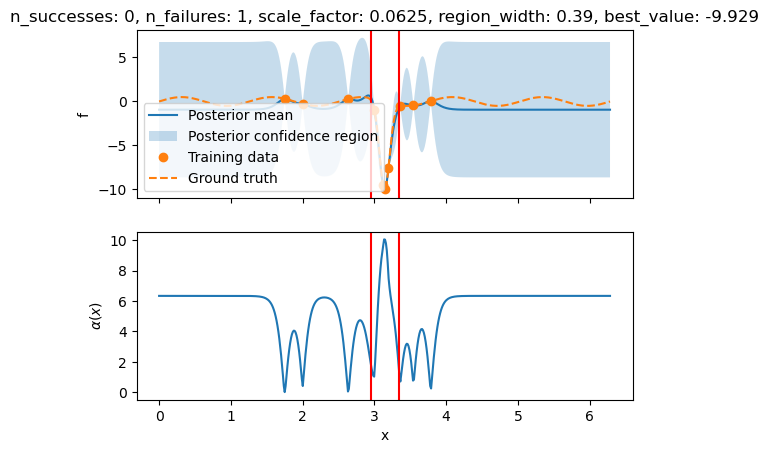

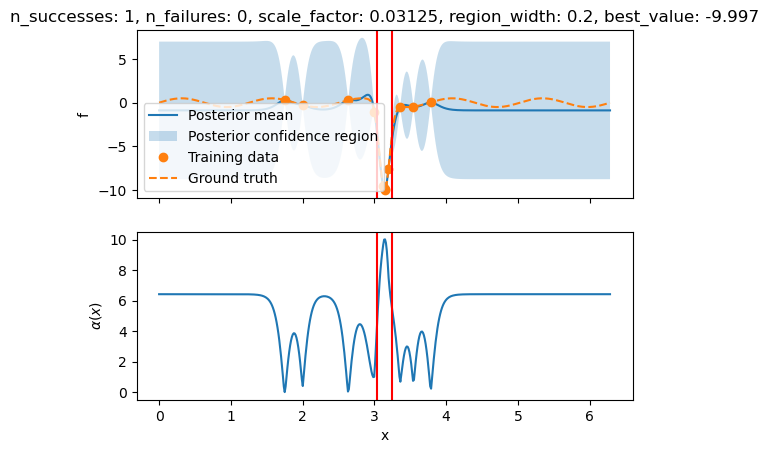

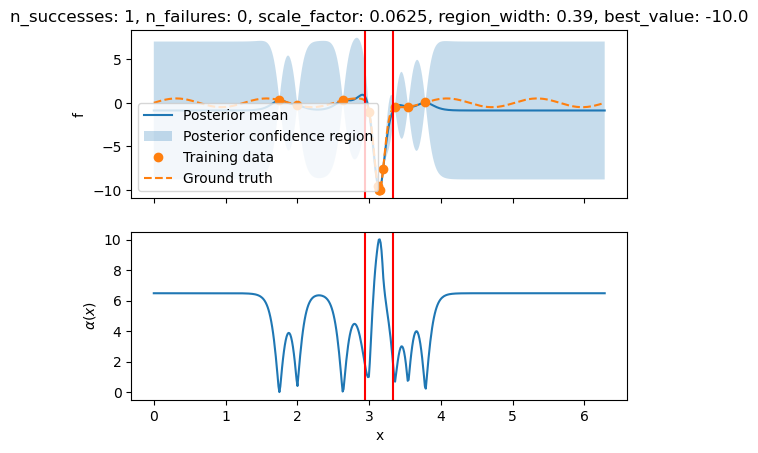

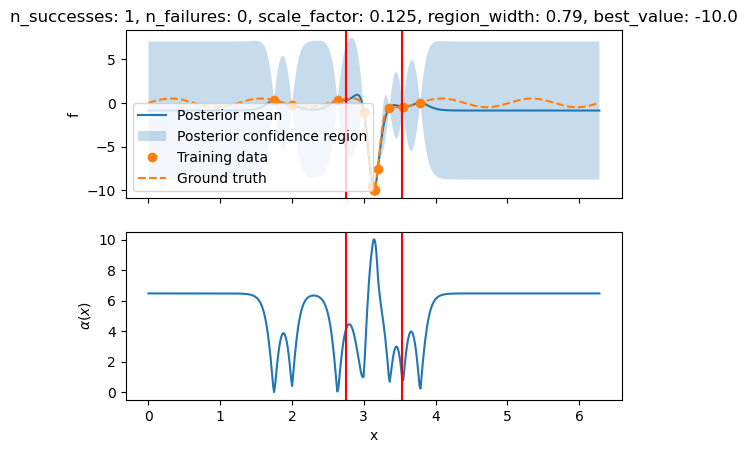

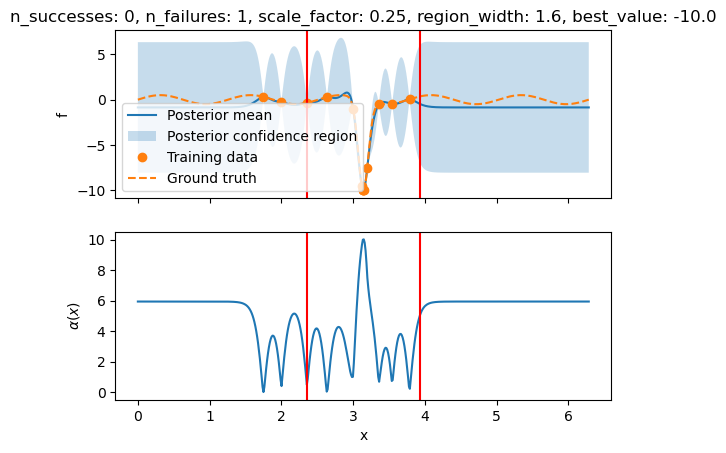

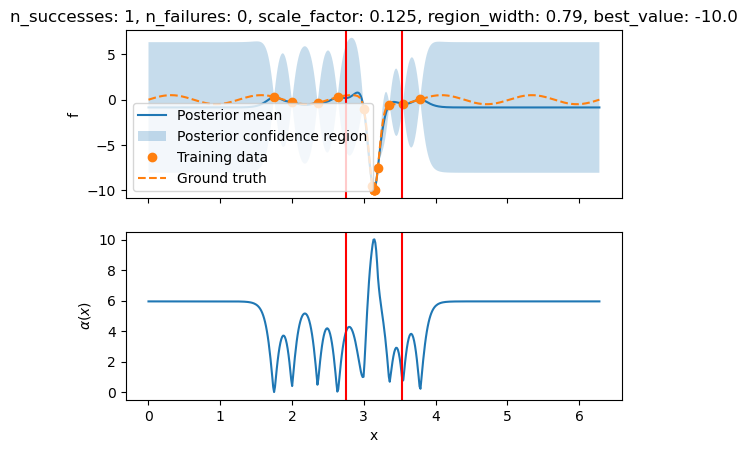

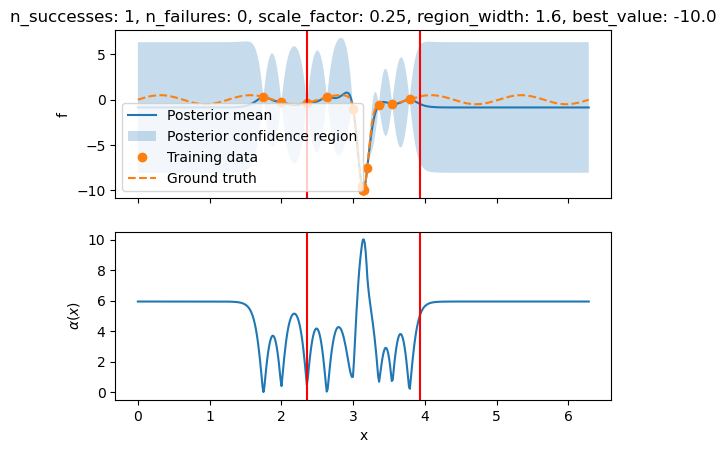

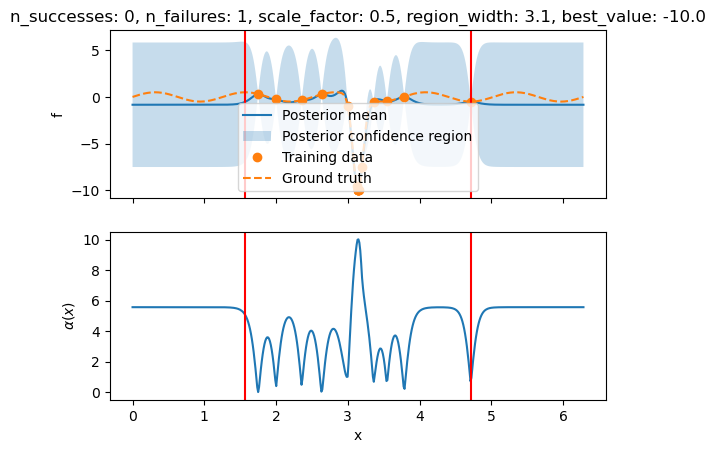

In [7]:
import torch
import matplotlib.pyplot as plt

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(),500).double()

for i in range(15):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # get trust region
    trust_region = generator.get_trust_region(torch.tensor(vocs.bounds)).squeeze()
    scale_factor = generator.turbo_state.length
    region_width = trust_region[1] - trust_region[0]
    best_value = generator.turbo_state.best_value

    # get number of successes and failures
    n_successes = generator.turbo_state.success_counter
    n_failures = generator.turbo_state.failure_counter

    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)

    # calculate model posterior and acquisition function at each test point
    # NOTE: need to add a dimension to the input tensor for evaluating the
    # posterior and another for the acquisition function, see
    # https://botorch.org/docs/batching for details
    # NOTE: we use the `torch.no_grad()` environment to speed up computation by
    # skipping calculations for backpropagation
    with torch.no_grad():
        posterior = model.posterior(test_x.unsqueeze(1))
        acq_val = acq(test_x.reshape(-1,1,1))

    # get mean function and confidence regions
    mean = posterior.mean
    l,u = posterior.mvn.confidence_region()

    # plot model and acquisition function
    fig,ax = plt.subplots(2,1,sharex="all")

    # add title for successes and failures
    ax[0].set_title(f"n_successes: {n_successes}, n_failures: {n_failures}, "
                    f"scale_factor: {scale_factor}, region_width: {region_width:.2}, "
                    f"best_value: {best_value:.4}")

    # plot model posterior
    ax[0].plot(test_x, mean, label="Posterior mean")
    ax[0].fill_between(test_x, l, u,alpha=0.25, label="Posterior confidence region")

    # add data to model plot
    ax[0].plot(X.data["x"],X.data["f"],"C1o", label="Training data")

    # plot true function
    true_f = sin_function({"x": test_x})["f"]
    ax[0].plot(test_x, true_f,'--', label="Ground truth")

    # add legend
    ax[0].legend()

    # plot acquisition function
    ax[1].plot(test_x, acq_val.flatten())

    ax[0].set_ylabel("f")
    ax[1].set_ylabel(r"$\alpha(x)$")
    ax[1].set_xlabel("x")

    # plot trust region
    for a in ax:
        a.axvline(trust_region[0],c="r")
        a.axvline(trust_region[1],c="r")

    # do the optimization step
    X.step()


In [8]:
# access the collected data
generator.get_trust_region(torch.tensor(vocs.bounds))

tensor([[2.3571],
        [3.9279]], dtype=torch.float64)

In [9]:
X.data

,x,f,xopt_runtime,xopt_error
1,3.000000,-1.021664,0.000016,False
2,1.750000,0.312362,0.000004,False
3,2.000000,-0.272011,0.000002,False
4,3.785398,0.038679,0.000013,False
5,2.635408,0.286708,0.000012,False
6,3.196350,-7.544618,0.000010,False
7,3.357763,-0.534625,0.000012,False
8,3.151377,-9.929166,0.000011,False
9,3.544077,-0.452030,0.000026,False
10,3.121284,-9.545284,0.000011,False
